In [1]:
%matplotlib inline


## Example: applying the PathCORE software to a FastICA model of the normalized _P. aeruginosa_ gene compendium.

This example is run after the normalized _P. aeruginosa_ compendium has been downloaded. You can download the compendium from the Zenodo record [here](https://zenodo.org/record/583694) or use the [shell script in the `../data` directory](https://github.com/greenelab/PathCORE-analysis/blob/master/data/download_data.sh) (keep in mind this script will download more than just the compendium). 

In [2]:
print(__doc__)

from functools import partial
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathcore import CoNetwork
from pathcore import aggregate_permuted_network, \
        network_edges_permutation_test
from pathcore import pathway_enrichment_with_overlap_correction
import seaborn as sns
from sklearn.decomposition import FastICA

Automatically created module for IPython interactive environment


#### Specify data file paths

In [3]:
data_dir = os.path.join("..", "data")
pao1_data_dir = os.path.join(data_dir, "pao1_data")
gene_compendium = os.path.join(pao1_data_dir, "all-pseudomonas-gene-normalized.pcl")
pathways = os.path.join(pao1_data_dir, "pseudomonas_KEGG_terms.txt")

#### Other constants

In [4]:
n_features = 300

gene_signature_std = 2.5

n_permutations = 1000
permutation_test_alpha = 0.05

In [5]:
compendium_df = pd.read_table(gene_compendium)
compendium_df.set_index("Gene_symbol", inplace=True)

# Compute ICA
ica = FastICA(n_components=n_features, whiten=True, random_state=42)
_ = ica.fit_transform(compendium_df.T)  # Reconstruct signals
weight_matrix = ica.mixing_  # Get estimated mixing matrix

In [6]:
gene_feature_weights = {}
for index, gene_weights in enumerate(weight_matrix):
    gene = compendium_df.index[index]
    gene_feature_weights[gene] = list(gene_weights)

weight_matrix_df = pd.DataFrame.from_dict(gene_feature_weights,
                                       orient="index")

### Determine our gene signature rule(s)

In [7]:
col_averages = np.mean(weight_matrix, axis=0)
print("Mean centered at 0: {0}".format(np.mean(col_averages)))
print("Mean standard deviation of each feature: {0}".format(np.mean(np.std(weight_matrix, axis=0))))

Mean centered at 0: -0.0004845554056544623
Mean standard deviation of each feature: 0.2826567790160395


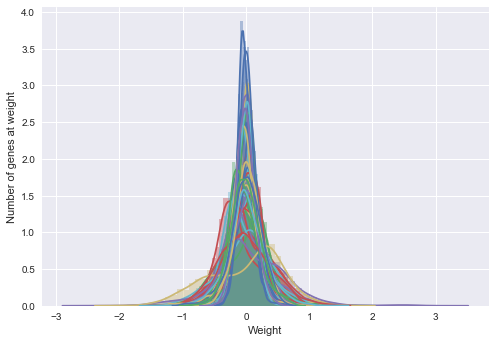

In [8]:
sns.set(color_codes=True)
def plot_feature_weight_distributions(end_feature, dataframe):
    fig, ax = plt.subplots()
    for i in range(0, end_feature):
        sns.distplot(weight_matrix[:,i])
    ax.set_xlabel("Weight")
    ax.set_ylabel("Number of genes at weight")
    plt.show()
plot_feature_weight_distributions(50, weight_matrix)

Note the similarity between this function and the ones we define in [`constants/gene_signature_definitions.py`](https://github.com/kathyxchen/PathCORE-analysis/blob/master/constants/gene_signature_definitions.py):

In [9]:
def define_FastICA_gene_signature(std=2.5):
    def _gene_signature(feature_weight_vector, std):
        mean = feature_weight_vector.mean()
        cutoff = std * feature_weight_vector.std()
        positive_gene_signature = set(
            feature_weight_vector[(feature_weight_vector >=
                                   mean + cutoff)].index)
        negative_gene_signature = set(
                feature_weight_vector[(feature_weight_vector <=
                                       mean - cutoff)].index)
        return positive_gene_signature, negative_gene_signature

    return partial(_gene_signature, std=std)

### Define functions used for loading the pathway definitions and running the PathCORE analysis workflow

In [10]:
def load_pathway_definitions(path_to_file, shorten_pathway_names=None):
    """
    See documentation: https://github.com/greenelab/PathCORE-analysis/blob/master/utils.py#L31
    """
    pathway_definitions = pd.read_table(
        path_to_file, header=None,
        names=["pw", "size", "genes"])
    pathway_definitions["genes"] = pathway_definitions["genes"].map(
        lambda x: x.split(";"))
    pathway_definitions.set_index("pw", inplace=True)
    pathway_definitions_map = {}
    for index, row in pathway_definitions.iterrows():
        if shorten_pathway_names:
            index = shorten_pathway_names(index)
        pathway_definitions_map[index] = set(row["genes"])
    return pathway_definitions_map

In [11]:
def process(current_weight_matrix, pathway_definitions,
            partial_function_signature,
            alpha=0.05, correct_all_genes=True,
            metadata=False):
    """
    See documentation: https://github.com/greenelab/PathCORE-analysis/blob/master/run_network_creation.py#L155
    Modifications:
    * Removed the `overlap_correction` parameter for this example
      - overlap correction will be applied by default.
    * `current_weight_matrix` is just a pandas.DataFrame rather
      than a tuple of a filename and a pandas.DataFrame
    """
    n_genes, _ = current_weight_matrix.shape
    significant_pathways_df = pd.DataFrame()
    feature_metadata = {}
    for feature in current_weight_matrix:
        feature_df, additional = \
            pathway_enrichment_with_overlap_correction(
                current_weight_matrix[feature], pathway_definitions,
                partial_function_signature,
                alpha=alpha, correct_all_genes=correct_all_genes,
                metadata=metadata)
        if feature_df is not None:
            feature_df.loc[:, "feature"] = pd.Series(
                [feature] * len(feature_df.index), index=feature_df.index)
            significant_pathways_df = pd.concat(
                [significant_pathways_df, feature_df], axis=0)
            if additional:
                feature_metadata[feature] = additional
    significant_pathways_df.reset_index(drop=True, inplace=True)
    return {"significant_pathways": significant_pathways_df,
            "feature_metadata": feature_metadata}

In [12]:
pathway_definitions = load_pathway_definitions(pathways)

### PathCORE network creation step (based on [this script](https://github.com/greenelab/PathCORE-analysis/blob/master/run_network_creation.py))

In [13]:
output = process(
    weight_matrix_df, pathway_definitions,
    define_FastICA_gene_signature(gene_signature_std))

129 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
118 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
129 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
129 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
105 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
107 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
129 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
130 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
132 adjustments made to a vector of length 186 containing the raw weight

In [14]:
significant_pathways = output["significant_pathways"]

features =[0, 17, 43]
for feature in features:
    feature_pathways = significant_pathways[significant_pathways.feature == feature].pathway
    print("{0} pathways significant in feature {1}".format(len(feature_pathways), feature))
    print("{0}\n".format(feature_pathways))

4 pathways significant in feature 0
0         KEGG-Module-M00334: Type VI secretion system
1    KEGG-Pathway-pae02024: Quorum sensing - Pseudo...
2    KEGG-Pathway-pae00520: Amino sugar and nucleot...
3    KEGG-Pathway-pae00280: Valine, leucine and iso...
Name: pathway, dtype: object

1 pathways significant in feature 17
35    KEGG-Pathway-pae00280: Valine, leucine and iso...
Name: pathway, dtype: object

6 pathways significant in feature 43
102    KEGG-Module-M00709: Macrolide resistance, MacA...
103    KEGG-Module-M00328: Hemophore/metalloprotease ...
104    KEGG-Module-M00721: Cationic antimicrobial pep...
105    KEGG-Pathway-pae01210: 2-Oxocarboxylic acid me...
106    KEGG-Pathway-pae00630: Glyoxylate and dicarbox...
107    KEGG-Pathway-pae00350: Tyrosine metabolism - P...
Name: pathway, dtype: object



In [15]:
model_network = CoNetwork(
    n_features, significant_pathways=significant_pathways)

In [16]:
model_network_df = model_network.to_dataframe()
model_network_df[model_network_df.weight > 1]

The pathway co-occurrence network contains 91 pathways.


,pw0,pw1,weight,features
101,"KEGG-Module-M00178: Ribosome, bacteria",KEGG-Pathway-pae03010: Ribosome - Pseudomonas ...,23,1.0 14.0 49.0 56.0 65.0 66.0 118.0 119.0 120.0...
251,KEGG-Module-M00334: Type VI secretion system,KEGG-Pathway-pae02024: Quorum sensing - Pseudo...,10,0.0 30.0 36.0 60.0 101.0 114.0 156.0 187.0 196...
259,"KEGG-Pathway-pae00280: Valine, leucine and iso...",KEGG-Pathway-pae02024: Quorum sensing - Pseudo...,10,0.0 47.0 51.0 111.0 112.0 187.0 192.0 196.0 23...
423,"KEGG-Pathway-pae00280: Valine, leucine and iso...",KEGG-Pathway-pae00627: Aminobenzoate degradati...,9,51.0 73.0 104.0 112.0 121.0 163.0 232.0 240.0 ...
15,KEGG-Pathway-pae00190: Oxidative phosphorylati...,KEGG-Pathway-pae03010: Ribosome - Pseudomonas ...,9,56.0 66.0 118.0 140.0 146.0 194.0 277.0 285.0 ...
348,KEGG-Pathway-pae02024: Quorum sensing - Pseudo...,KEGG-Pathway-pae02040: Flagellar assembly - Ps...,8,75.0 79.0 87.0 121.0 161.0 198.0 240.0 270.0
17,"KEGG-Module-M00178: Ribosome, bacteria",KEGG-Pathway-pae00190: Oxidative phosphorylati...,8,56.0 66.0 118.0 140.0 146.0 277.0 285.0 289.0
91,"KEGG-Module-M00009: Citrate cycle (TCA cycle, ...","KEGG-Module-M00178: Ribosome, bacteria",7,1.0 49.0 65.0 127.0 146.0 214.0 243.0
112,"KEGG-Module-M00644: Vanadium resistance, efflu...",KEGG-Pathway-pae02024: Quorum sensing - Pseudo...,7,30.0 36.0 51.0 54.0 90.0 112.0 233.0
125,"KEGG-Module-M00156: Cytochrome c oxidase, cbb3...",KEGG-Pathway-pae00220: Arginine biosynthesis -...,7,23.0 33.0 35.0 77.0 149.0 177.0 257.0


### PathCORE permutation test (based on [this script](https://github.com/greenelab/PathCORE-analysis/blob/master/run_permutation_test.py#L146))

In [17]:
permutations = []
for i in range(n_permutations):
    # `aggregate_permutated_network` takes in a list of networks right now.
    # adjusting the `random_state` parameter in FastICA would allow us to
    # generate multiple networks from different ICA models, adding an extra
    # stability assessment for the pathway-pathway relationships identified.
    permutations.append(aggregate_permuted_network([model_network]))

In [18]:
final_network = network_edges_permutation_test(
    model_network, permutations, permutation_test_alpha,
    n_networks=1)

78 edges are significant under the null distribution, generated from 1000 permutations, for alpha = 0.05.


Edges in the network after the permutation test are weighted by their **odds ratios**. The odds ratio is computed by dividing the observed edge weight by the expected edge weight (the average of its non-zero edge weight distribution). If the observed edge does not show up in any of the permuted networks, divide by 1 (no change).

In [19]:
for edge, edge_obj in final_network.edges.items():
    if edge_obj.significant:
        print(final_network.get_edge_pathways(edge))
        print("\t ODDS RATIO (EDGE WEIGHT): {0}\n".format(edge_obj.weight))

('KEGG-Module-M00236: Putative polar amino acid transport system', 'KEGG-Pathway-pae00920: Sulfur metabolism - Pseudomonas aeruginosa PAO1')
	 ODDS RATIO (EDGE WEIGHT): 3.965811965811966

('KEGG-Pathway-pae00280: Valine, leucine and isoleucine degradation - Pseudomonas aeruginosa PAO1', 'KEGG-Pathway-pae00340: Histidine metabolism - Pseudomonas aeruginosa PAO1')
	 ODDS RATIO (EDGE WEIGHT): 3.7966101694915255

('KEGG-Pathway-pae00190: Oxidative phosphorylation - Pseudomonas aeruginosa PAO1', 'KEGG-Pathway-pae03010: Ribosome - Pseudomonas aeruginosa PAO1')
	 ODDS RATIO (EDGE WEIGHT): 4.67430441898527

('KEGG-Module-M00324: Dipeptide transport system', 'KEGG-Module-M00334: Type VI secretion system')
	 ODDS RATIO (EDGE WEIGHT): 2.794811320754717

('KEGG-Module-M00178: Ribosome, bacteria', 'KEGG-Pathway-pae00190: Oxidative phosphorylation - Pseudomonas aeruginosa PAO1')
	 ODDS RATIO (EDGE WEIGHT): 4.510586811857229

('KEGG-Module-M00223: Phosphonate transport system', 'KEGG-Module-M00331: T